### Read Data


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
from scipy.stats import anderson_ksamp

# Get data source
data_dir = 'data_process/12-06/'

# RR
rr = data_dir + 'afterPI_rr_1207_1initdeltat_4dot5sigmapm_train_test_split_repeats_data_rep500.csv'

# AA, WSR, RSR
aa_wsr_rsr = data_dir + 'afterPI_1207_2params_03_train_test_split_repeats_data_rep500.csv'

# Read in as dataframe.
df_aa_wsr_rsr = pd.read_csv(aa_wsr_rsr)
df_rr = pd.read_csv(rr)

# Columns
SIM_AA = 'sim_aas'
SIM_WSR = 'sim_wsrs'
SIM_RSR = 'sim_rsrs'
SIM_RRTC = 'Simulated and Tuned Durations'
SIM_RRER = 'Simulated and Tuned Errors'
HUM_AA = 'hum_test_aas'
HUM_WSR = 'hum_test_wsrs'
HUM_RSR = 'hum_test_rsrs'
HUM_RRTC = 'Human Test Durations'
HUM_RRER = 'Human Test Errors'

highlight_colour = (0.561, 0.208, 0.043)

### Plot

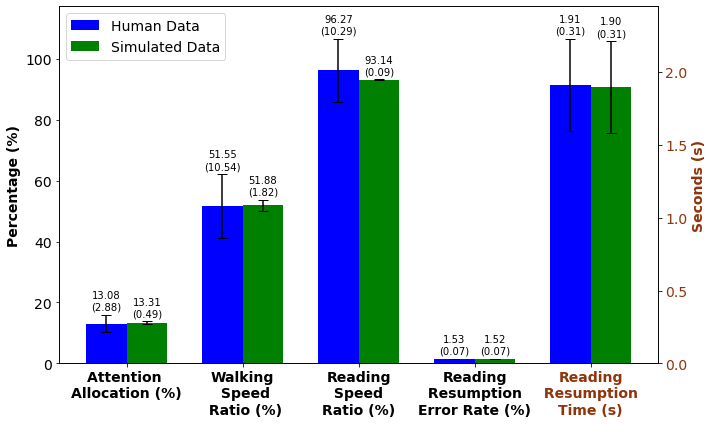

In [2]:
# Define the column pairs for human and simulated data
metric_pairs_perct = [
    ('hum_test_aas', 'sim_aas'),
    ('hum_test_wsrs', 'sim_wsrs'),
    ('hum_test_rsrs', 'sim_rsrs'),
    ('Human Test Errors', 'Simulated and Tuned Errors')  # This is a percentage metric
]

# Reading Resumption Time is the only metric for the second axis
metric_pair_time = [
    ('Human Test Durations', 'Simulated and Tuned Durations')
]

# Function to adjust y-limit
def adjust_ylim(ax, mean, std):
    y_max = mean + std
    ax.set_ylim(0, y_max * 1.1)  # Adding a bit of margin to the top

# Function to add annotations
def add_annotations(ax, rect, mean, std, heignt_leviation, is_percentage=True):
    format_str = "{:.2f}\n({:.2f})" if is_percentage else "{:.2f}s\n({:.2f}s)"
    height = rect.get_height()
    ax.annotate(format_str.format(mean, std), 
                (rect.get_x() + rect.get_width() / 2, height + std + heignt_leviation), 
                ha='center', va='bottom')


# Set up the matplotlib figure and two axes
fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
bar_width = 0.35  # Define bar width
n_pairs = len(metric_pairs_perct) + len(metric_pair_time)
index = np.arange(n_pairs)  # Define the index for the x-axis positions

# Plot data from df_aa_wsr_rsr with percentage scale and std
# Store means and stds for adjusting ylim later
means = []
stds = []
for i, (hum_col, sim_col) in enumerate(metric_pairs_perct):
    if i <=2:
        df = df_aa_wsr_rsr
        ratio = 100
    else:
        df = df_rr
        ratio = 1
    hum_mean = df[hum_col].mean() * ratio  # Convert to percentage
    sim_mean = df[sim_col].mean() * ratio  # Convert to percentage
    hum_std = df[hum_col].std() * ratio  # Standard deviation to percentage
    sim_std = df[sim_col].std() * ratio  # Standard deviation to percentage
    means.extend([hum_mean, sim_mean])
    stds.extend([hum_std, sim_std])
    
    hum_bar = ax1.bar(index[i] - bar_width/2, hum_mean, bar_width, yerr=hum_std, capsize=5, color='blue', label='Human Data' if i == 0 else "")
    sim_bar = ax1.bar(index[i] + bar_width/2, sim_mean, bar_width, yerr=sim_std, capsize=5, color='green', label='Simulated Data' if i == 0 else "")
    
    # Annotate the bars with mean and std
    add_annotations(ax1, hum_bar[0], hum_mean, hum_std, 1)
    add_annotations(ax1, sim_bar[0], sim_mean, sim_std, 1)

# Plot data from df_rr with std
for i, (hum_col, sim_col) in enumerate(metric_pair_time, start=len(metric_pairs_perct)):
    hum_mean = df_rr[hum_col].mean()
    sim_mean = df_rr[sim_col].mean()
    hum_std = df_rr[hum_col].std()
    sim_std = df_rr[sim_col].std()
    means.extend([hum_mean, sim_mean])
    stds.extend([hum_std, sim_std])
    
    hum_bar = ax2.bar(index[i] - bar_width/2, hum_mean, bar_width, yerr=hum_std, capsize=5, color='blue', label='Human Data' if i == len(metric_pairs_perct) else "")
    sim_bar = ax2.bar(index[i] + bar_width/2, sim_mean, bar_width, yerr=sim_std, capsize=5, color='green', label='Simulated Data' if i == len(metric_pairs_perct) else "")
    
    # Annotate the bars with mean and std
    add_annotations(ax2, hum_bar[0], hum_mean, hum_std, 0.02)
    add_annotations(ax2, sim_bar[0], sim_mean, sim_std, 0.02)

    
rsrs_mean = df_aa_wsr_rsr[HUM_RSR].mean() * 100
rsrs_std = df_aa_wsr_rsr[HUM_RSR].std() * 100
# Adjust the ylim based on the collected means and stds
adjust_ylim(ax1, rsrs_mean, rsrs_std)
adjust_ylim(ax2, df_rr[HUM_RRTC].mean(), df_rr[HUM_RRTC].std())

# Set labels for both y-axes
ax1.set_ylabel('Percentage (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Seconds (s)', color=highlight_colour, fontsize=14, fontweight='bold')

# Set x-ticks and labels for the combined plot, with different color for the time metric
x_labels = ['Attention \nAllocation (%)', 'Walking\n Speed\n Ratio (%)', 'Reading\n Speed \nRatio (%)', 
            'Reading\n Resumption \nError Rate (%)', 'Reading\n Resumption \nTime (s)']
ax1.set_xticks(index)
ax1.set_xticklabels(x_labels, fontsize=14, fontweight='bold')

ax1.get_xticklabels()[-1].set_color(highlight_colour)  # Change the color of the last label
ax1.tick_params(axis='x', labelsize=14, )
ax2.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14, labelcolor='black')
ax2.tick_params(axis='y', labelsize=14, labelcolor=highlight_colour)

# Only display legend once, but include information from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', fontsize=14)
ax1.legend(handles1, labels1, loc='upper left', fontsize=14)

# Show the plot with a tight layout
plt.tight_layout()

# Save the plot
plt.savefig(data_dir + "study4_multitasking_metrics.png", format='png', dpi=300)

# Show the plot
plt.show()